In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
mb_size = 64
Z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


""" Generator Net model """
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [4]:
G_sample = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

for it in range(1000000):
    if it % 1000 == 0:
        n_sample = 16

        Z_sample = sample_Z(n_sample, Z_dim)
        y_sample = np.zeros(shape=[n_sample, y_dim])
        y_sample[:, 7] = 1

        samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, y_mb = mnist.train.next_batch(mb_size)

    Z_sample = sample_Z(mb_size, Z_dim)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_sample, y:y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

Iter: 0
D loss: 1.154
G_loss: 2.885

Iter: 1000
D loss: 0.008435
G_loss: 7.116

Iter: 2000
D loss: 0.03351
G_loss: 4.994

Iter: 3000
D loss: 0.03918
G_loss: 5.816

Iter: 4000
D loss: 0.2288
G_loss: 5.427

Iter: 5000
D loss: 0.2368
G_loss: 6.157

Iter: 6000
D loss: 0.3188
G_loss: 5.883

Iter: 7000
D loss: 0.2982
G_loss: 4.412

Iter: 8000
D loss: 0.4319
G_loss: 3.094

Iter: 9000
D loss: 0.514
G_loss: 3.216

Iter: 10000
D loss: 0.6572
G_loss: 3.159

Iter: 11000
D loss: 0.9101
G_loss: 2.737

Iter: 12000
D loss: 0.6296
G_loss: 2.752

Iter: 13000
D loss: 0.8721
G_loss: 2.675

Iter: 14000
D loss: 0.5727
G_loss: 2.592

Iter: 15000
D loss: 0.8524
G_loss: 2.137

Iter: 16000
D loss: 0.7343
G_loss: 2.151

Iter: 17000
D loss: 0.6932
G_loss: 2.095

Iter: 18000
D loss: 0.6953
G_loss: 1.769

Iter: 19000
D loss: 0.7536
G_loss: 1.757

Iter: 20000
D loss: 0.9833
G_loss: 1.77

Iter: 21000
D loss: 0.9043
G_loss: 1.986

Iter: 22000
D loss: 0.7375
G_loss: 1.784

Iter: 23000
D loss: 0.9367
G_loss: 1.911

Iter

Iter: 68000
D loss: 0.6478
G_loss: 1.967

Iter: 69000
D loss: 0.6584
G_loss: 2.252

Iter: 70000
D loss: 0.6758
G_loss: 2.232

Iter: 71000
D loss: 0.8513
G_loss: 2.003

Iter: 72000
D loss: 0.7124
G_loss: 2.07

Iter: 73000
D loss: 0.6935
G_loss: 2.219

Iter: 74000
D loss: 1.052
G_loss: 1.506

Iter: 75000
D loss: 0.7942
G_loss: 2.103

Iter: 76000
D loss: 0.671
G_loss: 1.913

Iter: 77000
D loss: 0.602
G_loss: 1.756

Iter: 78000
D loss: 0.822
G_loss: 1.813

Iter: 79000
D loss: 0.6818
G_loss: 1.953

Iter: 80000
D loss: 0.7235
G_loss: 1.986

Iter: 81000
D loss: 0.7674
G_loss: 2.072

Iter: 82000
D loss: 0.6732
G_loss: 1.95

Iter: 83000
D loss: 0.8237
G_loss: 2.095

Iter: 84000
D loss: 0.8755
G_loss: 1.907

Iter: 85000
D loss: 0.6251
G_loss: 1.886

Iter: 86000
D loss: 0.6431
G_loss: 1.838

Iter: 87000
D loss: 0.6878
G_loss: 1.929

Iter: 88000
D loss: 0.5637
G_loss: 2.196

Iter: 89000
D loss: 0.6162
G_loss: 2.112

Iter: 90000
D loss: 0.7447
G_loss: 2.038

Iter: 91000
D loss: 0.7365
G_loss: 1.793

Iter: 136000
D loss: 0.8774
G_loss: 1.836

Iter: 137000
D loss: 0.8337
G_loss: 2.06

Iter: 138000
D loss: 0.9802
G_loss: 2.06

Iter: 139000
D loss: 0.9292
G_loss: 2.093

Iter: 140000
D loss: 0.6626
G_loss: 1.839

Iter: 141000
D loss: 0.8165
G_loss: 1.906

Iter: 142000
D loss: 0.7814
G_loss: 1.948

Iter: 143000
D loss: 0.7132
G_loss: 1.773

Iter: 144000
D loss: 0.8407
G_loss: 2.164

Iter: 145000
D loss: 0.76
G_loss: 1.648

Iter: 146000
D loss: 0.8512
G_loss: 1.563

Iter: 147000
D loss: 0.8492
G_loss: 2.022

Iter: 148000
D loss: 0.6369
G_loss: 2.034

Iter: 149000
D loss: 0.791
G_loss: 1.731

Iter: 150000
D loss: 0.6137
G_loss: 1.982

Iter: 151000
D loss: 0.8172
G_loss: 1.565

Iter: 152000
D loss: 0.7739
G_loss: 2.061

Iter: 153000
D loss: 0.7458
G_loss: 2.34

Iter: 154000
D loss: 0.6948
G_loss: 2.102

Iter: 155000
D loss: 0.8637
G_loss: 1.901

Iter: 156000
D loss: 0.6638
G_loss: 2.08

Iter: 157000
D loss: 0.811
G_loss: 2.074

Iter: 158000
D loss: 0.7343
G_loss: 1.864

Iter: 159000
D loss

Iter: 203000
D loss: 0.8841
G_loss: 1.892

Iter: 204000
D loss: 0.723
G_loss: 2.083

Iter: 205000
D loss: 0.6817
G_loss: 1.975

Iter: 206000
D loss: 0.5936
G_loss: 1.874

Iter: 207000
D loss: 0.6832
G_loss: 1.853

Iter: 208000
D loss: 0.7976
G_loss: 2.32

Iter: 209000
D loss: 0.7111
G_loss: 1.854

Iter: 210000
D loss: 0.7485
G_loss: 1.514

Iter: 211000
D loss: 0.7006
G_loss: 2.176

Iter: 212000
D loss: 0.8032
G_loss: 2.238

Iter: 213000
D loss: 0.6445
G_loss: 2.664

Iter: 214000
D loss: 0.6648
G_loss: 2.113

Iter: 215000
D loss: 0.7952
G_loss: 2.13

Iter: 216000
D loss: 0.7625
G_loss: 1.966

Iter: 217000
D loss: 0.7926
G_loss: 2.022

Iter: 218000
D loss: 0.6536
G_loss: 2.035

Iter: 219000
D loss: 0.541
G_loss: 2.451

Iter: 220000
D loss: 0.7525
G_loss: 2.026

Iter: 221000
D loss: 0.7939
G_loss: 1.878

Iter: 222000
D loss: 0.5909
G_loss: 2.262

Iter: 223000
D loss: 0.7439
G_loss: 1.883

Iter: 224000
D loss: 0.8866
G_loss: 2.123

Iter: 225000
D loss: 0.6297
G_loss: 2.013

Iter: 226000
D 

Iter: 270000
D loss: 0.608
G_loss: 2.06

Iter: 271000
D loss: 0.8114
G_loss: 1.898

Iter: 272000
D loss: 0.7561
G_loss: 3.154

Iter: 273000
D loss: 0.6394
G_loss: 2.187

Iter: 274000
D loss: 0.664
G_loss: 1.97

Iter: 275000
D loss: 0.5858
G_loss: 2.079

Iter: 276000
D loss: 0.7576
G_loss: 2.288

Iter: 277000
D loss: 0.7137
G_loss: 1.845

Iter: 278000
D loss: 0.6729
G_loss: 1.937

Iter: 279000
D loss: 0.662
G_loss: 2.122

Iter: 280000
D loss: 0.7636
G_loss: 2.026

Iter: 281000
D loss: 0.5923
G_loss: 2.134

Iter: 282000
D loss: 0.7488
G_loss: 2.026

Iter: 283000
D loss: 0.6321
G_loss: 1.912

Iter: 284000
D loss: 0.639
G_loss: 2.412

Iter: 285000
D loss: 0.7755
G_loss: 2.412

Iter: 286000
D loss: 0.6887
G_loss: 2.042

Iter: 287000
D loss: 0.7234
G_loss: 1.994

Iter: 288000
D loss: 0.6485
G_loss: 1.904

Iter: 289000
D loss: 0.8407
G_loss: 2.356

Iter: 290000
D loss: 0.5931
G_loss: 2.17

Iter: 291000
D loss: 0.5743
G_loss: 2.066

Iter: 292000
D loss: 0.9189
G_loss: 2.014

Iter: 293000
D los

Iter: 337000
D loss: 0.6643
G_loss: 2.435

Iter: 338000
D loss: 0.6994
G_loss: 2.023

Iter: 339000
D loss: 0.6927
G_loss: 2.279

Iter: 340000
D loss: 0.8816
G_loss: 1.972

Iter: 341000
D loss: 0.6624
G_loss: 2.047

Iter: 342000
D loss: 0.6237
G_loss: 2.246

Iter: 343000
D loss: 0.6891
G_loss: 2.038

Iter: 344000
D loss: 0.7592
G_loss: 2.249

Iter: 345000
D loss: 0.6616
G_loss: 2.176

Iter: 346000
D loss: 0.5281
G_loss: 1.982

Iter: 347000
D loss: 0.5838
G_loss: 2.517

Iter: 348000
D loss: 0.6984
G_loss: 2.289

Iter: 349000
D loss: 0.7173
G_loss: 1.929

Iter: 350000
D loss: 0.6941
G_loss: 2.376

Iter: 351000
D loss: 0.6955
G_loss: 2.401

Iter: 352000
D loss: 0.7671
G_loss: 2.436

Iter: 353000
D loss: 0.5563
G_loss: 2.572

Iter: 354000
D loss: 1.126
G_loss: 2.418

Iter: 355000
D loss: 0.6524
G_loss: 2.21

Iter: 356000
D loss: 0.5777
G_loss: 2.214

Iter: 357000
D loss: 0.7489
G_loss: 1.899

Iter: 358000
D loss: 0.6069
G_loss: 2.728

Iter: 359000
D loss: 0.6571
G_loss: 2.16

Iter: 360000
D

Iter: 404000
D loss: 0.5695
G_loss: 2.05

Iter: 405000
D loss: 0.675
G_loss: 2.116

Iter: 406000
D loss: 0.7629
G_loss: 2.048

Iter: 407000
D loss: 0.5496
G_loss: 2.453

Iter: 408000
D loss: 0.5779
G_loss: 2.374

Iter: 409000
D loss: 0.7079
G_loss: 1.999

Iter: 410000
D loss: 0.6984
G_loss: 1.91

Iter: 411000
D loss: 0.722
G_loss: 2.222

Iter: 412000
D loss: 0.5684
G_loss: 2.636

Iter: 413000
D loss: 0.6957
G_loss: 2.42

Iter: 414000
D loss: 0.5301
G_loss: 2.061

Iter: 415000
D loss: 0.7748
G_loss: 1.955

Iter: 416000
D loss: 0.6567
G_loss: 2.373

Iter: 417000
D loss: 0.7485
G_loss: 2.396

Iter: 418000
D loss: 0.569
G_loss: 2.484

Iter: 419000
D loss: 0.6112
G_loss: 2.164

Iter: 420000
D loss: 0.5799
G_loss: 2.14

Iter: 421000
D loss: 0.6349
G_loss: 2.485

Iter: 422000
D loss: 0.6262
G_loss: 2.532

Iter: 423000
D loss: 0.6285
G_loss: 2.428

Iter: 424000
D loss: 0.6774
G_loss: 1.763

Iter: 425000
D loss: 0.5341
G_loss: 2.304

Iter: 426000
D loss: 0.5649
G_loss: 2.506

Iter: 427000
D los

Iter: 471000
D loss: 0.6212
G_loss: 2.814

Iter: 472000
D loss: 0.4281
G_loss: 2.523

Iter: 473000
D loss: 0.623
G_loss: 2.103

Iter: 474000
D loss: 0.5488
G_loss: 2.627

Iter: 475000
D loss: 0.7545
G_loss: 2.526

Iter: 476000
D loss: 0.5053
G_loss: 2.508

Iter: 477000
D loss: 0.5962
G_loss: 2.402

Iter: 478000
D loss: 0.4577
G_loss: 2.342

Iter: 479000
D loss: 0.5709
G_loss: 2.036

Iter: 480000
D loss: 0.5511
G_loss: 2.363

Iter: 481000
D loss: 0.506
G_loss: 2.297

Iter: 482000
D loss: 0.6321
G_loss: 2.38

Iter: 483000
D loss: 0.4857
G_loss: 2.379

Iter: 484000
D loss: 0.6144
G_loss: 2.592

Iter: 485000
D loss: 0.6461
G_loss: 2.136

Iter: 486000
D loss: 0.6054
G_loss: 2.516

Iter: 487000
D loss: 0.5922
G_loss: 2.125

Iter: 488000
D loss: 0.5075
G_loss: 2.189

Iter: 489000
D loss: 0.6188
G_loss: 2.16

Iter: 490000
D loss: 0.7332
G_loss: 2.157

Iter: 491000
D loss: 0.6843
G_loss: 2.144

Iter: 492000
D loss: 0.5637
G_loss: 2.155

Iter: 493000
D loss: 0.645
G_loss: 2.044

Iter: 494000
D l

Iter: 538000
D loss: 0.754
G_loss: 2.191

Iter: 539000
D loss: 0.5981
G_loss: 2.535

Iter: 540000
D loss: 0.6
G_loss: 2.455

Iter: 541000
D loss: 0.7149
G_loss: 2.19

Iter: 542000
D loss: 0.5071
G_loss: 2.307

Iter: 543000
D loss: 0.6044
G_loss: 2.2

Iter: 544000
D loss: 0.6261
G_loss: 2.523

Iter: 545000
D loss: 0.7422
G_loss: 2.097

Iter: 546000
D loss: 0.5534
G_loss: 2.19

Iter: 547000
D loss: 0.6688
G_loss: 2.099

Iter: 548000
D loss: 0.6206
G_loss: 2.334

Iter: 549000
D loss: 0.5273
G_loss: 2.41

Iter: 550000
D loss: 0.726
G_loss: 1.848

Iter: 551000
D loss: 0.6514
G_loss: 2.243

Iter: 552000
D loss: 0.5506
G_loss: 2.297

Iter: 553000
D loss: 0.7602
G_loss: 2.37

Iter: 554000
D loss: 0.5159
G_loss: 2.216

Iter: 555000
D loss: 0.6068
G_loss: 2.318

Iter: 556000
D loss: 0.7554
G_loss: 2.048

Iter: 557000
D loss: 0.6251
G_loss: 2.692

Iter: 558000
D loss: 0.498
G_loss: 2.421

Iter: 559000
D loss: 0.6843
G_loss: 2.265

Iter: 560000
D loss: 0.6018
G_loss: 2.156

Iter: 561000
D loss: 0.

Iter: 606000
D loss: 0.5833
G_loss: 2.527

Iter: 607000
D loss: 0.5668
G_loss: 2.527

Iter: 608000
D loss: 0.6789
G_loss: 2.849

Iter: 609000
D loss: 0.802
G_loss: 1.991

Iter: 610000
D loss: 0.7091
G_loss: 2.462

Iter: 611000
D loss: 0.5819
G_loss: 2.457

Iter: 612000
D loss: 0.5861
G_loss: 2.516

Iter: 613000
D loss: 0.566
G_loss: 2.583

Iter: 614000
D loss: 0.5543
G_loss: 2.005

Iter: 615000
D loss: 0.6819
G_loss: 2.415

Iter: 616000
D loss: 0.6875
G_loss: 2.437

Iter: 617000
D loss: 0.4592
G_loss: 2.508

Iter: 618000
D loss: 0.8425
G_loss: 2.706

Iter: 619000
D loss: 0.7982
G_loss: 2.484

Iter: 620000
D loss: 0.5762
G_loss: 2.023

Iter: 621000
D loss: 0.5161
G_loss: 2.608

Iter: 622000
D loss: 0.7391
G_loss: 2.055

Iter: 623000
D loss: 0.8249
G_loss: 2.149

Iter: 624000
D loss: 0.5997
G_loss: 2.707

Iter: 625000
D loss: 0.7966
G_loss: 1.872

Iter: 626000
D loss: 0.4834
G_loss: 3.1

Iter: 627000
D loss: 0.7096
G_loss: 2.602

Iter: 628000
D loss: 0.836
G_loss: 2.257

Iter: 629000
D l

Iter: 673000
D loss: 0.6142
G_loss: 2.171

Iter: 674000
D loss: 0.3967
G_loss: 2.399

Iter: 675000
D loss: 0.625
G_loss: 2.56

Iter: 676000
D loss: 0.7338
G_loss: 2.32

Iter: 677000
D loss: 0.7688
G_loss: 2.147

Iter: 678000
D loss: 0.5295
G_loss: 2.136

Iter: 679000
D loss: 0.5333
G_loss: 2.362

Iter: 680000
D loss: 0.6188
G_loss: 2.44

Iter: 681000
D loss: 0.6618
G_loss: 2.06

Iter: 682000
D loss: 0.7263
G_loss: 2.674

Iter: 683000
D loss: 0.5971
G_loss: 2.246

Iter: 684000
D loss: 0.5729
G_loss: 2.458

Iter: 685000
D loss: 0.6403
G_loss: 2.253

Iter: 686000
D loss: 0.6213
G_loss: 2.168

Iter: 687000
D loss: 0.5635
G_loss: 2.382

Iter: 688000
D loss: 0.4637
G_loss: 2.504

Iter: 689000
D loss: 0.4455
G_loss: 2.472

Iter: 690000
D loss: 0.6068
G_loss: 2.111

Iter: 691000
D loss: 0.611
G_loss: 2.398

Iter: 692000
D loss: 0.7186
G_loss: 2.175

Iter: 693000
D loss: 0.6275
G_loss: 2.46

Iter: 694000
D loss: 0.7551
G_loss: 2.562

Iter: 695000
D loss: 0.5947
G_loss: 2.377

Iter: 696000
D los

Iter: 740000
D loss: 0.4801
G_loss: 2.767

Iter: 741000
D loss: 0.6165
G_loss: 2.241

Iter: 742000
D loss: 0.3286
G_loss: 2.843

Iter: 743000
D loss: 0.4819
G_loss: 2.493

Iter: 744000
D loss: 0.6097
G_loss: 2.177

Iter: 745000
D loss: 0.4835
G_loss: 2.251

Iter: 746000
D loss: 0.6007
G_loss: 2.818

Iter: 747000
D loss: 0.5727
G_loss: 2.153

Iter: 748000
D loss: 0.6677
G_loss: 2.888

Iter: 749000
D loss: 0.6422
G_loss: 2.375

Iter: 750000
D loss: 0.5485
G_loss: 2.487

Iter: 751000
D loss: 0.6131
G_loss: 2.53

Iter: 752000
D loss: 0.5985
G_loss: 2.385

Iter: 753000
D loss: 0.6266
G_loss: 2.441

Iter: 754000
D loss: 0.5808
G_loss: 2.357

Iter: 755000
D loss: 0.5695
G_loss: 2.558

Iter: 756000
D loss: 0.5109
G_loss: 2.445

Iter: 757000
D loss: 0.5099
G_loss: 2.367

Iter: 758000
D loss: 0.4899
G_loss: 2.784

Iter: 759000
D loss: 0.5931
G_loss: 2.725

Iter: 760000
D loss: 0.6052
G_loss: 2.335

Iter: 761000
D loss: 0.6599
G_loss: 2.737

Iter: 762000
D loss: 0.6735
G_loss: 2.634

Iter: 763000

Iter: 807000
D loss: 0.6135
G_loss: 2.75

Iter: 808000
D loss: 0.4202
G_loss: 2.428

Iter: 809000
D loss: 0.5486
G_loss: 2.817

Iter: 810000
D loss: 0.5506
G_loss: 2.481

Iter: 811000
D loss: 0.7797
G_loss: 2.514

Iter: 812000
D loss: 0.7063
G_loss: 2.583

Iter: 813000
D loss: 0.5784
G_loss: 2.43

Iter: 814000
D loss: 0.6261
G_loss: 3.085

Iter: 815000
D loss: 0.5909
G_loss: 2.124

Iter: 816000
D loss: 0.5579
G_loss: 2.933

Iter: 817000
D loss: 0.5704
G_loss: 2.34

Iter: 818000
D loss: 0.7946
G_loss: 2.421

Iter: 819000
D loss: 0.5127
G_loss: 2.592

Iter: 820000
D loss: 0.6233
G_loss: 2.162

Iter: 821000
D loss: 0.5693
G_loss: 2.381

Iter: 822000
D loss: 0.6437
G_loss: 2.055

Iter: 823000
D loss: 0.5012
G_loss: 2.964

Iter: 824000
D loss: 0.5148
G_loss: 2.562

Iter: 825000
D loss: 0.5406
G_loss: 2.691

Iter: 826000
D loss: 0.4414
G_loss: 2.503

Iter: 827000
D loss: 0.6568
G_loss: 2.773

Iter: 828000
D loss: 0.6181
G_loss: 2.879

Iter: 829000
D loss: 0.49
G_loss: 2.388

Iter: 830000
D l

Iter: 874000
D loss: 0.4955
G_loss: 2.657

Iter: 875000
D loss: 0.6287
G_loss: 2.713

Iter: 876000
D loss: 0.7282
G_loss: 2.479

Iter: 877000
D loss: 0.6392
G_loss: 2.447

Iter: 878000
D loss: 0.8097
G_loss: 2.15

Iter: 879000
D loss: 0.556
G_loss: 2.427

Iter: 880000
D loss: 0.5834
G_loss: 2.444

Iter: 881000
D loss: 0.8327
G_loss: 2.634

Iter: 882000
D loss: 0.7422
G_loss: 1.999

Iter: 883000
D loss: 0.5906
G_loss: 2.587

Iter: 884000
D loss: 0.5378
G_loss: 2.146

Iter: 885000
D loss: 0.6242
G_loss: 2.35

Iter: 886000
D loss: 0.6017
G_loss: 2.316

Iter: 887000
D loss: 0.5338
G_loss: 2.575

Iter: 888000
D loss: 0.734
G_loss: 2.423

Iter: 889000
D loss: 0.5513
G_loss: 2.192

Iter: 890000
D loss: 0.5566
G_loss: 2.981

Iter: 891000
D loss: 0.8212
G_loss: 2.55

Iter: 892000
D loss: 0.4937
G_loss: 2.381

Iter: 893000
D loss: 0.5529
G_loss: 3.024

Iter: 894000
D loss: 0.652
G_loss: 2.073

Iter: 895000
D loss: 0.4933
G_loss: 2.247

Iter: 896000
D loss: 0.4389
G_loss: 3.327

Iter: 897000
D lo

Iter: 941000
D loss: 0.6717
G_loss: 2.415

Iter: 942000
D loss: 0.5881
G_loss: 2.438

Iter: 943000
D loss: 0.6263
G_loss: 2.583

Iter: 944000
D loss: 0.4567
G_loss: 2.725

Iter: 945000
D loss: 0.5689
G_loss: 2.315

Iter: 946000
D loss: 0.5032
G_loss: 2.248

Iter: 947000
D loss: 0.4916
G_loss: 3.011

Iter: 948000
D loss: 0.5437
G_loss: 3.145

Iter: 949000
D loss: 0.582
G_loss: 3.742

Iter: 950000
D loss: 0.5879
G_loss: 2.896

Iter: 951000
D loss: 0.4486
G_loss: 2.75

Iter: 952000
D loss: 0.5294
G_loss: 2.274

Iter: 953000
D loss: 0.4835
G_loss: 2.651

Iter: 954000
D loss: 0.6874
G_loss: 2.913

Iter: 955000
D loss: 0.6507
G_loss: 2.338

Iter: 956000
D loss: 0.6881
G_loss: 2.481

Iter: 957000
D loss: 0.6033
G_loss: 2.75

Iter: 958000
D loss: 0.7364
G_loss: 2.805

Iter: 959000
D loss: 0.6469
G_loss: 2.961

Iter: 960000
D loss: 0.4871
G_loss: 2.828

Iter: 961000
D loss: 0.3754
G_loss: 3.055

Iter: 962000
D loss: 0.6502
G_loss: 2.629

Iter: 963000
D loss: 0.5218
G_loss: 2.98

Iter: 964000
D 

In [0]:
!ls out

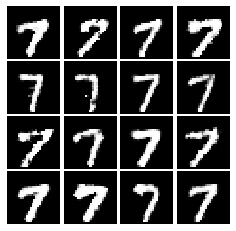

In [9]:
from IPython.display import Image
Image('./out/500.png')

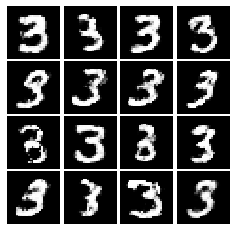

In [22]:
n_sample = 16

Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, 3] = 1

samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()

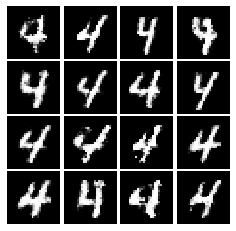

In [23]:
n_sample = 16

Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, 4] = 1

samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()

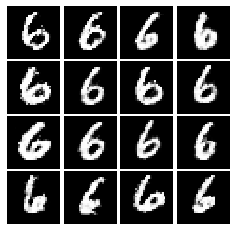

In [24]:
n_sample = 16

Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, 6] = 1

samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()

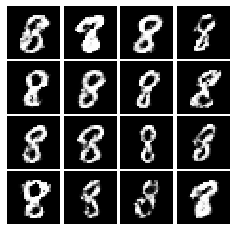

In [25]:
n_sample = 16

Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, 8] = 1

samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()

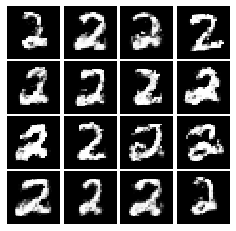

In [26]:
n_sample = 16

Z_sample = sample_Z(n_sample, Z_dim)
y_sample = np.zeros(shape=[n_sample, y_dim])
y_sample[:, 2] = 1

samples = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.show()